# **Accelerate LLM to the maximum. How I created a cross-platform Flash Attention with support for Turing+ architectures and more**

Today, transformers rule the hype ball in the world of machine learning, especially after the advent of ChatGPT and similar language models. This is made possible by the attention mechanism underlying their architecture, but it is also a weak point in terms of performance and memory consumption. Although the elegant Flash Attention (Tri Dao) concept has been developed in this regard, its existing implementations have a number of limitations. Therefore, I present to your attention the first and only open-source implementation of Flash Attention 2 on Triton with support for Linux and Windows, Turing-Blackwell architectures (now you can work in Google Colab and Kaggle), homo and heterogeneous clusters, optional determinism, as well as the ability to manually customize kernels for more flexible configuration for each GPU architecture is separate. More details about how it works and not only — further in the article.

## **Research engineering: from complex theory to even more complex practice**

There is a natural division in modern ML: researchers create new concepts and experiment on them, while ML engineers use ready-made tools based on them in production. But how are such tools created? Research engineering occupies a unique position, being at the junction of scientific research and engineering practice, and research engineers specialize in the implementation of complex mathematical ML concepts into effective and reliable production solutions. This requires not just a cursory acquaintance with theory, but a deep understanding of the mathematical foundations and programming skills at a level significantly higher than the training of ordinary ML specialists.

In practice, this means continuously studying new scientific papers, analyzing the source code of advanced repositories, as well as many attempts to write working code and conduct experiments to bring it to an acceptable level. For example, products like PyTorch, Hugging Face, ChatGPT or LangChain are being created by research engineers. Although such specialists are much less common and are mainly involved in top companies, sometimes, as experience shows, even small businesses need to develop completely closed and independent products. Flash Attention 2 on Triton was just the solution to a real problem when we had to adapt this algorithm to older GPUs and add the ability to manually adjust parameters. At the same time, such open-source projects can be of great benefit to the ML community, they serve as a visual demonstration of how research engineering is implemented in practice — it is for these reasons that I wanted to share something similar.

## **GPU Device: Highlights**

GPU performance in ML tasks is mostly determined not so much by the speed of calculations (although this is also a very important aspect), but by the effective use of memory. Therefore, to better understand the optimization of the attention mechanism, let's look at the main components and indicators of the modern Nvidia GPU architecture using the example of a factory.

**1. Performance indicators**

- FLOPS (Floating Point Operations Per Second) — theoretically the maximum number of floating point operations performed per second. For example, if this indicator is 10 TFLOPS, then up to 10 trillion operations per second can be performed on the GPU.
- Memory Bandwidth — the amount of data for read/write operations to various GPU memory levels per unit of time.
- Latency — the time from requesting to receiving data from various GPU memory levels.

**2. Streaming Multiprocessors (SM) — factory workshops**

Each SM is an autonomous production module containing:

- CUDA cores are universal machines for basic operations.
- Tensor cores are specialized pipelines for ultra-fast operations.
- SRAM and registers (more on this below).

**3. Executors & Schedulers — key employees**

- Thread — a single worker performing elementary operations.
- Warps (brigades) — groups of threads (usually 32) performing identical operations on different data. Any delay (for example, waiting for data) stops the entire group.
- Warp schedulers — dispatchers who distribute tasks between warps across CUDA cores in order to minimize their downtime.

**4. Memory hierarchy: warehouse system**

- HBM (High Bandwidth Memory) is the main storage, occupying the main amount of memory (tens of GB), but with relatively low bandwidth (~1.5-2.0 TB/s) and high latency compared to SRAM.
- L2 cache is an intermediate buffer between HBM and all SM, reducing the number of requests to frequently requested data with an average bandwidth (~5-7 TB/s) and a volume of several tens of MB.
- SRAM (Static Random-Access Memory) — a local buffer inside each SM. It has a small volume (64-256 KB per SM), but extremely high throughput (~18-20 TB/s). Starting with the Volta architecture, it is a single physical block that consists of 2 parts:
  - L1 cache (hardware-managed) — automatically reduces data access delays to L2 and HBM.
  - Shared Memory (programmable) — used for explicit data exchange between threads. It is this component that is critically important for Flash Attention to work.
- Registers — ultra-fast memory (~100 TB/s), private for each stream with the smallest amount (usually 128-256 bytes per stream).

**5. Kernel (software GPU core) — process card**

The kernel is a single set of instructions for parallel execution by threads on hardware cores using the SIMT (Single Instruction, Multiple Threads) model.

**6. Memory Controller — Logistics Department**

A memory controller is a specialized hardware unit that manages read/write operations for a specific GPU memory segment in such a way as to ensure maximum throughput and minimum latency for it. Modern GPUs have several such controllers, each of which serves its own memory channel in parallel.

**7. PCIe & NVLink — Data Backbone**

 PCI Express (Peripheral Component Interconnect Express) is a standard high-speed communication channel between GPU and CPU, providing access to system memory and control of GPU operation. It is a mandatory base standard for all configurations.

 NVLink (NVIDIA NVLink) is a specialized high-speed channel that allows multiple GPUs to exchange data directly (peer-to-peer) bypassing the CPU, which provides higher bandwidth (8-10 times) and lower latency. It is used as an add-on to PCIe.

## **Vanilla Attention: prerequisites for the appearance and the main drawback**

The emergence of the attention mechanism is a direct consequence of the development of vector representations of data and the limited potential of RNN architectures for their application. Let's look at these points in a little more detail.

### **What are embeddings and what are they for?**

Embeddings are a set of potential features in the form of trainable vectors necessary for a better description of the relationships between the elements of a sequence in an n-dimensional space. Using the example of a text, this means a vector representation of tokens (words or parts of text) in the space of their potential features in such a way that the geometric proximity between these vectors reflects the semantic and syntactic proximity of the corresponding words. Simply put, embeddings allow tokens of similar meaning to be located closer to each other in the feature space, and different tokens to be located further away.

In addition, embeddings can be positional and added to token embeddings, as implemented in transformers. For example, after learning, the embeddings of the words «king» and «queen» will have high geometric proximity (since both denote monarchs), but their vectors will differ along a certain dimension (conventionally, «gender»). Moreover, the vector operation «king - man + woman» will give a result as close as possible to the vector «queen», and positional embeddings will allow you to catch the difference between the sentences «The king rules the country, not the queen» and «The queen rules the country, not the king», which is very important in practice.

### **Architectural limitations of recurrent neural networks (RNNs)**

The RNN architecture has long been considered the standard for sequential data processing, based on the following principle: at each time step $t$ a new element enters the network along with the hidden state $H_t$ — a compact vector representation of the entire previous sequence. Schematically, in the simplest form, this can be represented as follows:

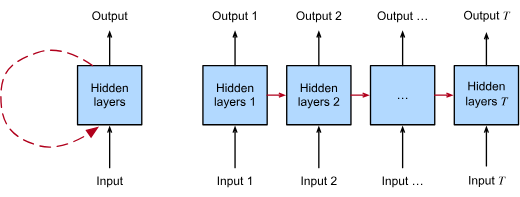

*Source: D2L book*

This causes the following problems:

- Loss of context on large sequences. The need to compress the entire sequence history into a single fixed-size vector leads to the loss of information due to its updating at each time step $t$, which is also known as information bottleneck.

- Difficulties of parallelism. Since calculations at each time step $t$ begin only after all calculations in the previous step $t-1$ are completed, this limits the possibility of parallel calculations on the GPU, which leads to their inefficient use. Partial solutions (RNN parallelization by batch, time blocks or layers) do not eliminate the problem completely.

- Training instability (explosion/decay of gradients). During Backpropagation Through Time, the computational graph must be expanded (or expanded) to the RNN using the same parameters at each time step. In this case, the gradient for each parameter should be summed over all the places where this parameter occurs in the deployed network. In this case, if the eigenvalues of the matrix of weights of the hidden state are greater or less than 1, this will lead to an explosion/decay of the gradients, respectively.

### **Now about Attention**

Initially, the attention mechanism was introduced for machine translation tasks (Bahdanau et al., 2014), the essence of which was the ability of the decoder to dynamically access various parts of the source sentence at each generation step through the calculation of attention weights represented as a weighted sum of encoder states. Later, this idea formed the basis of self-attention in transformers, where it was proposed to completely abandon RNN, as well as additionally use 3 linear projections (Q, K, V) for input embeddings. Let's analyze this intuition in more detail using the text example *«She rose (action) from the bed to smell the rose (flower)»*.

From the sentence above, it can be seen that the meaning of the word «rose» strongly depends on the context: in one case it means action, in the other — a plant. It turns out that the very context is determined by the connection of one word with others: with some it is stronger, and with some it is weaker. Therefore, to determine the relationship of each word with each other, it is necessary to somehow calculate their correlation with each other. The logical and at the same time simplest way seems to be to use input embeddings directly to determine the semantic proximity of their features through a scalar product (reflects the alignment of the vectors). In addition, if you pass the values obtained through softmax, you can get an interpretable matrix of attention weights: the closer the values are to one, the stronger the connection of the words. Simply put, such a matrix will allow the model to find out which words are worth paying more attention to when referring to the current word. Well, if you multiply the resulting weights by the initial embeddings, you will end up with new representations of tokens (words) containing all the information from the context. Mathematically, this can be represented as:

$$
W_{attn} = softmax(X X^T)
\\ Attention(X) = W_{attn} X
$$

However, this approach using embeddings directly has 2 critical drawbacks:
- 1. Since embeddings are primarily designed specifically to highlight features in a word due to their static nature, they will not be able to properly separate its meaning depending on the context. Simply put, in the feature space, «rose» as an action and «rose» as a flower will be geometrically close together (have a similar meaning) just because the embeddings do not know how to separate this very meaning in context.
- 2. The matrix of attention weights obtained in this way will be symmetrical, which means that it is unable to determine the direction of dependence in words, that is, to distinguish objects and subjects. In other words, this matrix will not show the difference between «she smells the rose» and «the rose smells her», although they are different things.

If embeddings in their pure form are not able to solve the above problems, then they need to be taught this, which is easily achieved through linear transformations. This means that it is enough to use linear projections with different weight matrices $W_q$ and $W_k$, which will allow projecting the initial embeddings into different subspaces Q (Queries) and K (Keys), so that as a result, attention scores become context-dependent and asymmetric. Also, to stabilize training, the product of Q and K is additionally scaled by $\sqrt{d_k}$ before applying softmax, which allows you to keep the variance of the output values within 1:

$$W_{attn} = softmax(\frac{Q K^T}{\sqrt{d_k}})$$

Now it is enough to add another linear transformation for the initial embeddings with the weight matrix $W_v$ in order to project them into the subspace V (Values), which will enhance relevant embeddings and suppress irrelevant ones depending on the context determined by the attention matrix $W_{attn}$. As a result, contextualized embeddings (attention output) will be obtained, where each token is presented taking into account the entire context of the sequence:

$$Attention(Q, K, V) = W_{attn} V = softmax(\frac{Q K^T}{\sqrt{d_k}}) V$$

Despite the popular analogy of Query/Key/Value with a search query in a database, this is a common misconception, and the names are purely historical in the context of neural networks. In reality, these are just 3 trainable linear projections designed for a specific task, namely for dynamically overweighting and transforming input features within a sequence. It is also worth adding that in tasks such as text generation (for example, in a transformer decoder), it is necessary to ensure autoregression, that is, that each current token sees only the previous ones. This is usually achieved by applying a causal mask $M$ (a matrix where $-\infty$ is below the main diagonal, and 0 is located on it and above) in front of softmax, which guarantees zero weights for future positions in the sequence:

$$Attention(Q, K, V) = softmax(\frac{Q K^T }{\sqrt{d_k}} + M) V$$

This idea can be further expanded by applying $h$ separate projections in parallel for each attention function, followed by concatenation and running through the final linear layer. This mechanism is called *multi-head attention* and it allows you to better focus on various aspects in the data, since each of the heads of attention is focused on learning its own projection:

$$
\begin{aligned}
&Head_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)
\\
&\text{MultiHead}(Q,K,V) = \text{Concat}(Head_1, \dots, Head_h)W^O
\end{aligned}
$$

Schematically, it looks like this:

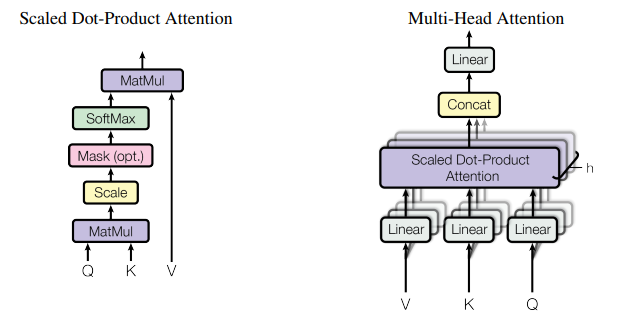

*Source: Attention Is All You Need*

Also below is a visualization of the work of multi-head attention on a text example, where the heads of attention are indicated in different colors:

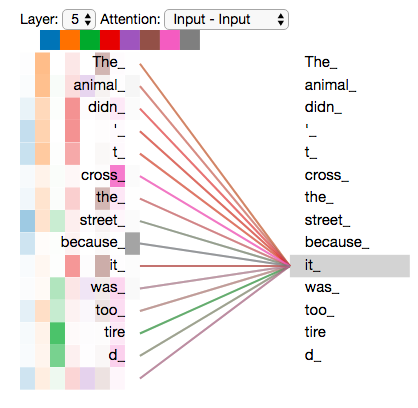

*Source: The Illustrated Transformer*

Besides the fact that the attention mechanism is devoid of the main disadvantages of RNN, it is also suitable for working with various types of data, including audio, video, images and so on, which makes it versatile. On the other hand, its main disadvantage is its quadratic complexity: $O(N^2d)$ in time, $O(N^2)$ by peak memory consumption and $\Theta (Nd+N^2)$ by I/O complexity (the number of read/write operations between different memory levels) relative to the length of the sequence $N$, where $d$ is the dimension of embeddings. It is these limitations (especially the last 2) that have led to the emergence of more effective methods such as Flash Attention, which will be discussed later.

## **What is Flash Attention and why is it Cool**

Initially, approximate methods were proposed to solve the problems described above by vanilla attention:

- Linformer: projection of keys and values into a smaller space.

- Performer: replacing softmax with kernel approximations via random features.

- Reformer: using local attention and hashing.

Their general idea is to sacrifice accuracy for linear complexity. These methods actually reached $O(nd)$ or $O(n\log(n))$ difficulties, but had serious compromises:

- approximation errors were introduced, affecting the quality of the models;

- architecture changes and overfitting of models were required;

- they often did not scale well on different types of data.

A little later, another approach was proposed: instead of changing the mathematics of the algorithm, optimize its implementation for modern GPUs. The key insight came from a deep analysis of vanilla attention's performance profile.

### **Flash Attention 1: The basic idea**

In the work (Tri Dao et al., 2022), it was found that vanilla attention is limited not so much by computing resources as by memory access operations (I/O), namely, multiple accesses to HBM for reading/writing $S=Q K^T$, $P= softmax(S)$ and $O = PV$, as well as storing $P$ to calculate gradients during backward pass. As a result, the authors of this paper proposed the Flash Attention algorithm, which reduces the number of read/write operations to HBM without approximating the results. This is achieved by organizing calculations in such a way that the intermediate matrices $S$ and $P$ are stored in SRAM, and only the final result $O$ (attention output) is recorded in HBM. This algorithm is based on 3 fundamental principles — let's look at them in more detail.

**Kernel Fusion** — if multiple operations are applied to the same input data, then this data can be loaded from HBM once, rather than several for each operation. This means that all the basic operations during the calculation of attention are combined into a single super-kernel, completely eliminating intermediate calls to HBM and multiple kernel launches. Compilers can automatically combine many operations on elements, however, in the context of model training, intermediate values still need to be written to HBM to be saved during backward pass, which reduces the efficiency of naive kernel fusion.

**Tiling (block splitting)** — the initial matrices Q, K, V are divided into blocks of size $2^n$ (usually at least 64 in size), which are placed in SRAM. Calculations occur sequentially, with each block being processed completely before moving on to the next.

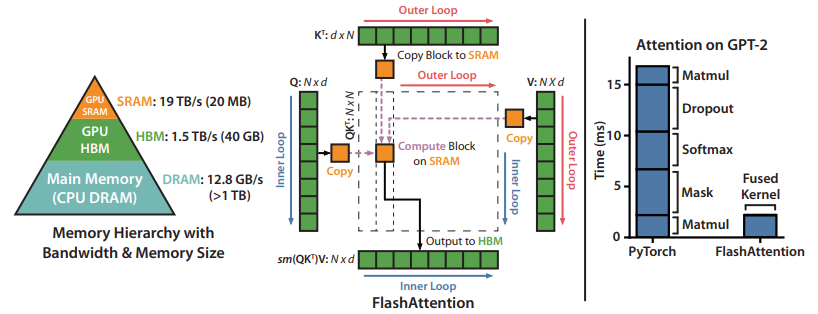

*Source: FlashAttention paper*

**Online Softmax** — instead of calculating softmax over the entire $S$ matrix at the same time, a numerically stable algorithm is used that processes the matrix in blocks, accumulating statistics (maxima and sums) for correct normalization. For simplicity, consider a 1-row block of the attention matrix $S$ of the form $[S^{(1)}, S^{(2)}]$ for some matrices $S^{(1)}, S^{(2)}\in\mathbb{R}^{B_r \times B_c}$, where $B_r$ and $B_c$ are the block sizes along the row and column axes, respectively. We need to calculate the softmax of this line block and multiply it by a matrix of values $V$ of the form $\begin{bmatrix} V^{(1)} \\V^{(2)} \end{bmatrix}$ for some matrices $V^{(1)}, V^{(2)} \in \mathbb{R}^{B_c \times d}$. Then the standard softmax is calculated as follows:

$$
\hspace{2em} \begin{aligned}[l]
&m = \max(\text{rowmax}(S^{(1)}), \text{rowmax}(S^{(2)})) \in \mathbb{R}^{B_r}
\\
&\ell = \text{rowsum}(e^{S^{(1)} - m}) + \text{rowsum}(e^{S^{(2)} - m}) \in \mathbb{R}^{B_r}
\\
&P = \begin{bmatrix} P^{(1)} & P^{(2)} \end{bmatrix} = \text{diag}(\ell)^{-1} \begin{bmatrix} e^{S^{(1)} - m} & e^{S^{(2)} - m} \end{bmatrix} \in \mathbb{R}^{B_r \times 2B_c}
\\
&O = \begin{bmatrix} P^{(1)} & P^{(2)} \end{bmatrix} \begin{bmatrix} V^{(1)} \\ V^{(2)} \end{bmatrix} = \text{diag}(\ell)^{-1} \left( e^{S^{(1)} - m} V^{(1)} + e^{S^{(2)} - m} V^{(2)} \right) \in \mathbb{R}^{B_r \times d}
\end{aligned}
$$

Instead, online softmax calculates the local softmax for each block and scales it to get the correct result at the end:

$$
\hspace{2em} \begin{aligned}[l]
&m^{(1)} = \text{rowmax}(S^{(1)}) \in \mathbb{R}^{B_r}
\\
&\ell^{(1)} = \text{rowsum}(e^{S^{(1)} - m^{(1)}}) \in \mathbb{R}^{B_r}
\\
&\tilde{P}^{(1)} = \text{diag}(\ell^{(1)})^{-1} e^{S^{(1)} - m^{(1)}} \in \mathbb{R}^{B_r \times B_c}
\\
&O^{(1)} = \tilde{P}^{(1)} V^{(1)} = \text{diag}(\ell^{(1)})^{-1} e^{S^{(1)} - m^{(1)}} V^{(1)} \in \mathbb{R}^{B_r \times d}
\\
&m^{(2)} = \max(m^{(1)}, \text{rowmax}(S^{(2)})) = m
\\
&\ell^{(2)} = e^{m^{(1)} - m^{(2)}} \ell^{(1)} + \text{rowsum}(e^{S^{(2)} - m^{(2)}}) = \text{rowsum}(e^{S^{(1)} - m}) + \text{rowsum}(e^{S^{(2)} - m}) = \ell
\\
&\tilde{P}^{(2)} = \text{diag}(\ell^{(2)})^{-1} e^{S^{(2)} - m^{(2)}}
\\
&O^{(2)} = \text{diag}(\ell^{(1)} / \ell^{(2)})^{-1} O^{(1)} + \tilde{P}^{(2)} V^{(2)} = \text{diag}(\ell^{(2)})^{-1} e^{S^{(1)} - m} V^{(1)} + \text{diag}(\ell^{(2)})^{-1} e^{S^{(2)} - m} V^{(2)} = O
\end{aligned}
$$

This calculation process is shown in the diagram below. For simplicity, it omits the step that subtracts each element by the maximum value along the lines:

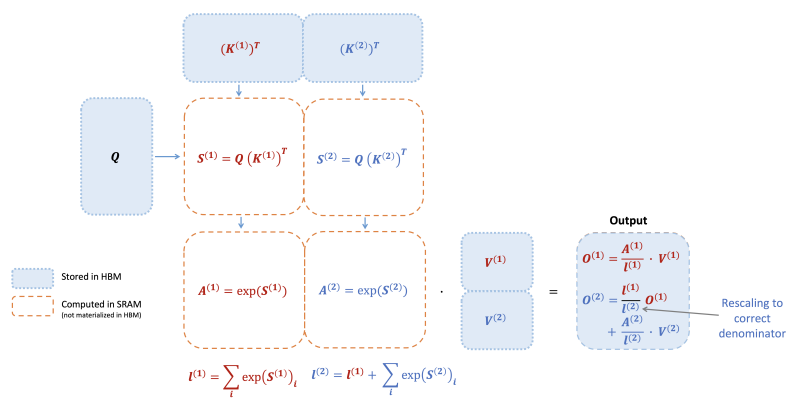

*Source: FlashAttention-2 paper*

**Backward pass solution**

For the standard implementation of attention, the principle of backward pass operation is as follows:

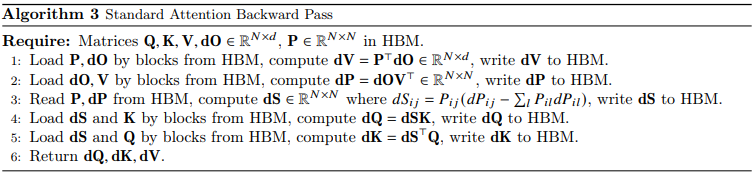

In the case of Flash Attention, there is no need to store the intermediate matrices $S$ and $P$ for calculating gradients, since the input data blocks Q, K, V have already been loaded into SRAM, where $S$ and $P$ will be recalculated, which will reduce peak memory consumption to $O(N)$. In addition to saving memory by 10-20 times, depending on the length of the sequence, this approach also speeds up the algorithm by 2-4 times in time. Although conceptually backward pass seems simpler compared to forward pass due to the lack of softmax rescaling, this implementation turns out to be much more complicated. This is because more values need to be stored in SRAM to perform 5 matrix multiplications instead of 2 in the forward pass. In any case, this reduces the I/O complexity to $\Theta ({N^2 d M^{-1}})$, which for typical values of $d$ (64-128) and $M$ (SRAM size) significantly reduces the number of calls to HBM (up to 9 times).

**Block-sparse Flash Attention** extends the original Flash Attention to an approximate version, introducing structural sparsity at the block level, which significantly reduces storage and computing costs for long contexts. Instead of materializing the full attention matrix, the algorithm performs all the steps only for the predefined, most important blocks marked in the mask (1 — calculate the block, 0 — skip). As a result, this algorithm works faster than any existing method of approximate attention.

**Experimental results and practical significance**

Flash Attention has demonstrated incredible performance results for transformers, as well as allowing you to work with previously unavailable sequence lengths. When testing on an 8xA100 GPU, the following results were obtained:

- 15% acceleration of BERT-large training on Wikipedia dataset relative to Nvidia MLPerf 1.1 when achieving target accuracy of 72% in 17.4 minutes instead of 20.
- Acceleration of GPT-2 training on the OpenWebtext dataset by 3 times relative to Hugging Face and by 1.7 times relative to Megatron-LM. For small models: 2.7 days instead of 9.5 and 4.7, respectively, medium: 6.9 instead of 21 and 11.5, respectively. At the same time, GPT-2 small with Flash Attention, with an increased sequence length up to 4k, still works 30% faster and reduces perplexity (a metric for the quality of language models) by 0.7 compared to Megatron-LM 1k.
- 2.4 times faster training on a set of Long-Range Arena (LRA) tasks compared to vanilla transformer.
- Flash Attention allowed a transformer with an exact attention mechanism to surpass a random baseline for the first time on a synthetic Path-X task (length 16K tokens), and block-sparse Flash Attention on Path—256 (length 64K tokens). In these tests, it is necessary to determine whether there is a path between two points in a 128x128 or 256x256 black-and-white image. The main difficulty lies in the fact that the image is fed into the model one pixel at a time, which creates extremely long input sequences.

Although Flash Attention provides a significant acceleration of experiments with large models, its main advantage is to reduce costs at all stages of the lifecycle — from prototyping and model training to inference in production. Now, to achieve similar results, 2-3 times less GPU is required, which significantly reduces both the cost of deploying and supporting projects, as well as the entry threshold for product development and market launch. In other words, this approach not only optimizes calculations, but also significantly increases the cost-effectiveness of transformer-based solutions. That's why Flash Attention is so cool, and as the further development of the field demonstrates, its potential for optimization is far from exhausted.

### **Flash Attention 2: What's new**

Despite the significant increase in efficiency compared to the standard attention mechanism, in the following work (Tri Dao et al., 2023), performance analysis showed that Flash Attention is still far from as effective as low-level primitives like optimized matrix multiplications (GEMM). In particular, the forward pass reaches only 30-50% of the theoretical maximum FLOPs/s on A100 GPU, and the backward pass reaches 25-35%, while for GEMM this figure is 80-90%. This is due to the suboptimal distribution of work between different blocks of threads and warps on the GPU, which leads either
to their low occupancy or to unnecessary read/write operations in shared memory. Let's look at the improvements that have eliminated these shortcomings.

**Updated online softmax**, aimed at reducing the number of operations that are not matrix multiplications (non-matmul FLOPs). This was made possible by two tricks:
- 1. *Delayed scaling of the output accumulator*. Instead of scaling both parts of the output update at each step, an "unscaled" version of the output accumulator is supported. Scaling is performed only once at the very end of the cycle for all blocks to get the correct result:

$$
\hspace{2em} \begin{aligned}[l]
&\tilde{O}^{(2)} = \text{diag}(\ell^{(1)})^{-1} {O}^{(1)} + e^{S^{(2)} - m^{(2)}} V^{(2)}
\\
&O^{(2)} = \text{diag}(\ell^{(2)})^{-1} \tilde{O}^{(2)} = O
\end{aligned}
$$

- 2. *Memory savings with backward pass*. To calculate gradients correctly, it is enough to store one combined tensor logsumexp $L^{(j)}= m^{(j)} +\log(\ell^{(j)})$ instead of the maxima of $m$ and the sums of the exponents of $\ell$.

Then in the case of 2 blocks, as in the example with Flash Attention 1, the modification of online-softmax will look like:

$$
\hspace{2em} \begin{aligned}[l]
&m^{(1)} = \text{rowmax}(S^{(1)}) \in \mathbb{R}^{B_r} \\
&\ell^{(1)} = \text{rowsum}(e^{S^{(1)} - m^{(1)}}) \in \mathbb{R}^{B_r} \\
&\tilde{O}^{(1)} = e^{S^{(1)} - m^{(1)}} V^{(1)} \in \mathbb{R}^{B_r \times d} \\
&m^{(2)} = \max(m^{(1)}, \text{rowmax}(S^{(2)})) = m \\
&\ell^{(2)} = e^{m^{(1)} - m^{(2)}} \ell^{(1)} + \text{rowsum}(e^{S^{(2)} - m^{(2)}}) = \text{rowsum}(e^{S^{(1)} - m}) + \text{rowsum}(e^{S^{(2)} - m}) = \ell \\
&\tilde{P}^{(2)} = \text{diag}(\ell^{(2)})^{-1} e^{S^{(2)} - m^{(2)}} \\
&\tilde{O}^{(2)} = \text{diag}(e^{m^{(1)} - m^{(2)}})^{-1} \tilde{O}^{(1)} + e^{S^{(2)} - m^{(2)}} V^{(2)} = e^{S^{(1)} - m} V^{(1)} + e^{S^{(2)} - m} V^{(2)} \\
&O^{(2)} = \text{diag}(\ell^{(2)})^{-1} \tilde{O}^{(2)} = O
\end{aligned}
$$

**Additional parallelism in the length of the sequence**, which, in the case of its large length, significantly speeds up the algorithm due to a higher load of multiprocessors (SM). This is implemented in 2 places:

- In forward pass, this is achieved through an external loop (along the length of the sequence), where each block of data Q will be executed independently in its thread block.
- Backward pass also uses parallelization along the length of the sequence in the outer loop, but not by blocks of Q rows as in forward, but by blocks of K/V columns, each of which will also be executed independently in its thread block. To eliminate the race condition due to simultaneous writing of partial amounts to $dQ_i$ from different thread blocks, the atomic operation *atomic-add* is used to ensure the correctness of calculations without data loss.

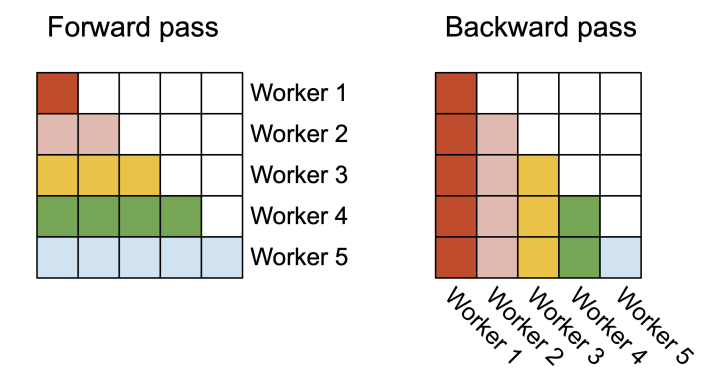

*Source: FlashAttention-2 paper*

Atomic operations are low-level processor instructions that ensure that a certain operation is performed on a memory location as a single, indivisible transaction, thus eliminating the possibility of overwriting the results by other threads. However, it should be borne in mind that using such operations does not ensure determinism (reproducibility of results even with a fixed random seed), since they do not take into account the order of execution between different thread blocks. If determinism is necessary, this mode should be made optional by adding sequential processing of K/V column blocks, but in this case, performance will decrease by 10-20%.

**Efficient division of work between warps**, aimed at minimizing read/write operations in shared memory, is also implemented in 2 locations:

- In the forward pass, instead of using the "split-K" scheme (when for each block $K$ and $V$ work was distributed among 4 warps, while $Q$ remained available for all warps), it was proposed to divide $Q$ between 4 warps, and $K$ and $V$ leave available for all warps:

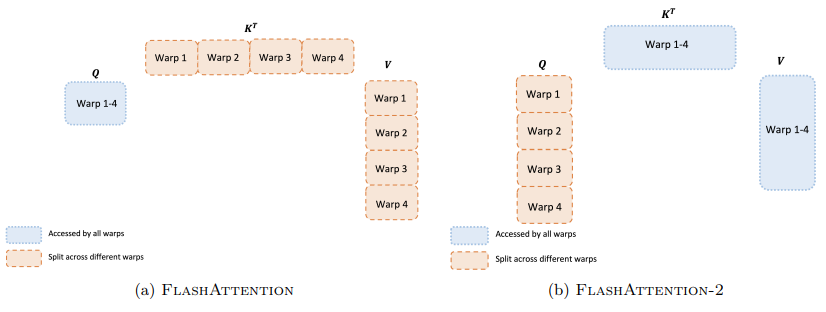

*Source: FlashAttention-2 paper*

- The backward pass uses a similar scheme, but it still requires some synchronization due to the more complex relationship between all the different inputs and the gradients $Q$, $K$, $V$, $O$, $dO$, $dQ$, $dK$, $dV$. However, even in this case, the volume of operations with shared memory is significantly reduced compared to the initial approach.

**Full operating principle of Flash Attention 2**:

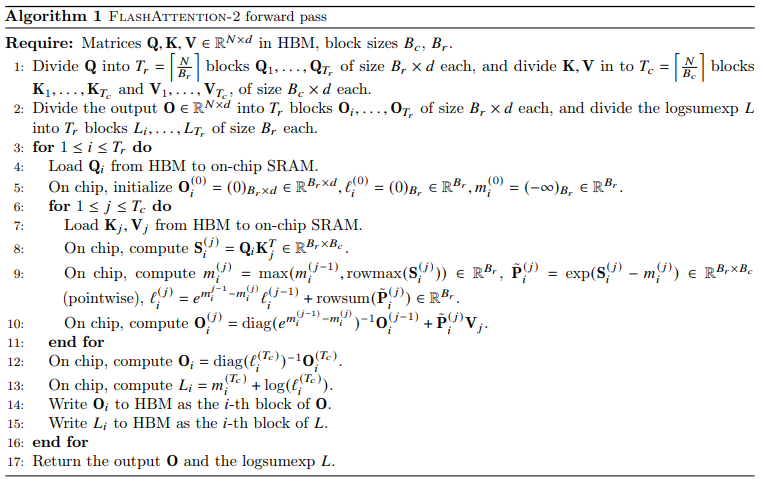

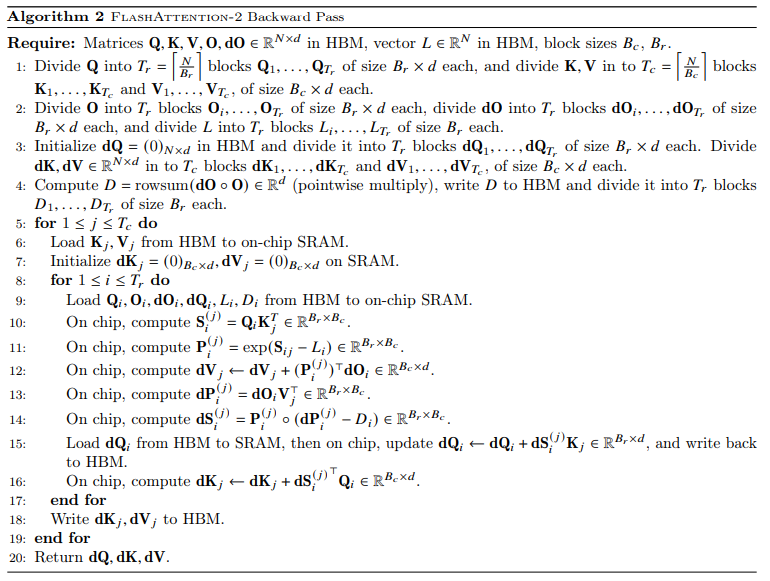

**Key performance results**

When testing Flash Attention 2 on the same hardware as Flash Attention 1, the following results were obtained:
- The speed of the kernel has increased about in 2 times.
- Peak computing power reaches 230 TFLOPs/s on the A100, which is 73% of the theoretical maximum for this chip.
- When training GPT models (1.3B and 2.7B parameters) on sequences of 2k and 8k tokens in length, using Flash Attention 2 gives a 1.3-fold acceleration compared to Flash Attention 1 and a 2.8-fold acceleration relative to the basic version without Flash Attention. 225 TFLOPs/s per A100 GPU was achieved (72% model FLOPs utilization).

Since Flash Attention 2 is on average twice as fast as its previous version, in practice this means reducing the cost of training models with a 16K context length to a level corresponding to the previous 8K. Simply put, this opens up access to models with twice the length of the context for the same money as before.

### **A few words about Flash Attention 3**

Although Flash Attention 2 showed good results on the A100, for newer architectures (Hopper and higher) it provides low GPU utilization, reaching only 35% of the theoretical maximum on the H100, while for GEMM this figure is 80-90%. Therefore, Flash Attention 3 can be considered as an adaptation of version 2 to new architectures, which significantly opens up their potential, eventually providing a 1.5-2x speed increase and utilization up to 75% on the H100, as well as working with much longer sequences. This was made possible by three innovations:

- **Using asynchronous Tensor Cores and TMA**. The Hopper architecture allows computing operations on Tensor Cores and data movement via Tensor Memory Accelerator (TMA) to be performed independently and in parallel. Warp specialization is used for this purpose, where some thread groups (warps) are responsible for loading data via TMA, while others are responsible for matrix multiplications via WGMMA, which ensures their effective overlap.

- **Overlap of GEMM and Softmax operations**. Since the bandwidth of the H100 for special functions (for example, exponents for softmax) is approximately 3.9 TFLOPS, which is 256 times less than for matrix operations in FP16, the *ping-pong scheduling* technique is used to hide softmax delays, which is based on the synchronization of barriers necessary to force the launch of a single warp group earlier than the other one. As a result, it increases performance by 10-15%. Moreover, a similar approach can be applied within a single warp group, which will give an even small increase in performance.

- **Efficient low precision operation (FP8)**. Using the FP8 format allows you to almost double the bandwidth of Tensor Cores, but creates the problem of high quantization error, especially due to outliers in LLM activations. Two key techniques are used to solve this problem:
  - *Block quantization*. Instead of using a single scale for the entire tensor, its own scale is calculated for each individual data block, which significantly improves accuracy.
  - *Incoherent Processing*. Before quantization, the tensors Q and K are multiplied by a random orthogonal matrix (Hadamard transform), which allows the outliers to be evenly distributed over all elements. This transform does not change the result of attention, but reduces the quantization error by 2.6 times compared to the basic FP8 implementation, allowing you to achieve almost 1.2 PFLOPS/s on the H100.

As you can see, the key optimizations of Flash Attention 3 relate exclusively to the latest GPU architectures, and creating a single high-performance and easily extensible solution for the entire family of architectures from Turing to Blackwell is fraught with significant implementation difficulties. That's why I chose to implement Flash Attention 2 as the most versatile and reliable option for production. Perhaps in the future I will make a separate implementation of Flash Attention 3 with its more detailed description, but so far it is not certain.

## **Why Triton and not CUDA**

Let's start with the fact that **CUDA (Compute Unified Device Architecture)** is a low-level framework from NVIDIA, which has long been the industry standard for writing GPU accelerators. In fact, this is the same C++ with extensions, where developers need to manually manage memory, threads, and shared memory usage. Although this gives you maximum control, writing efficient kernels turns into a complex and time-consuming task that requires in-depth knowledge of a specific GPU architecture, not to mention the ability to write in C++.

**Triton**, in turn, is a specialized language for writing DNN computing cores from OpenAI, which also provides maximum performance on modern GPUs, but with a Python-style interface. Triton has its own JIT compiler, which automatically handles many low-level optimizations, which in CUDA the developer has to answer for himself. The Triton code is several times shorter and clearer than its CUDA counterpart, since abstractions like block operations (tl.dot) and automatic memory management allow you to focus on the logic of the algorithm (for example, tiling or online softmax), rather than on routine low-level code. Although using Triton significantly simplifies development and provides CUDA-like performance, it has several limitations.:

- This is a relatively new project with a less developed community and training materials compared to CUDA.
- Limited integration with Nvidia profilers and debuggers (Nsight), which complicates deep diagnostics of bottlenecks in kernels.
- It may be difficult to integrate into existing projects based on specific CUDA libraries.
- It does not support Windows operation in its pure form.

It should be understood that Triton is not a universal replacement for CUDA, but rather a powerful specialized tool in a specific field. Specifically, in the case of Flash Attention, this means performance that is almost comparable to CUDA with significantly less code: ~800-1200 lines instead of ~3000-5000, depending on the implementation method. As a result, it makes developing and maintaining high-performance code much easier, and that's why I used Triton to implement Flash Attention 2.

## **Overview of key implementation features**

To begin with, let's look at popular Flash Attention 2 implementations: Dao AI Lab (CUDA, Triton), Pytorch (CUDA) and OpenAI (Triton). They have the following limitations:

- Limited support for hardware architectures. All of them work exclusively with Ampere and newer architectures, excluding support for widely used Turing GPUs (T4, RTX 20 series), which is critical for working in Google Colab and Kaggle.

- Lack of manual customization of kernels. None of the listed implementations provides the ability to manually configure computing cores (kernels) for specific GPU characteristics, which in practice turns out to be very useful, since specialized optimization can provide significant performance gains.

- Support for optional determinism out of the box. Explicit and documented control over the determinism of outcomes is only available in the Dao AI Lab's CUDA implementation. The PyTorch implementation requires thread synchronization via torch.cuda.synchronize to achieve this behavior, although this is not stated anywhere in the official documentation or tutorials.

- Triton stability issues. In addition to working only on Linux, versions of Triton 3.3.0 and higher have a bug related to increased shared memory consumption. This is especially noticeable on older architectures (Turing and Ampere) with previously functional configurations: blocks that previously fit into memory now cause it to overflow. At the same time, support for the Blackwell architecture requires these problematic versions of Triton, creating an additional compatibility conflict between the latest and outdated architectures.

- The uncertainty of working in heterogeneous environments. There is no information available on working in clusters with mixed GPU architectures, which creates risks with distributed training on heterogeneous hardware.

- Low quality of the code and the complexity of its support. All the considered implementations use code with uninformative variable names (for example, N_CTX, off_m, l_ij, start_n), minimal comments, and almost complete lack of documentation (docstrings). As a result, it makes it much more difficult for new developers to understand the algorithm, complicates debugging and further maintenance of the code base.

It was with these limitations in mind that I developed the implementation of Flash Attention 2 on Triton, designed to offer a universal, convenient and more flexible solution for developers. Its key features and approaches to their implementation are described below.

- **Support for Turing and higher architectures**. Previously, it was believed that Flash Attention was not capable of working with a Turing GPU, but during tests on T4, the optimal block sizes were empirically selected to fit them into shared memory. Legacy mode (Triton ≤3.2.0) uses 128x128 blocks for forward and 64x64 for backward pass. In modern mode (Triton ≥3.3.0) an asymmetric configuration of 128x32 for forward and 32x32 for backward is applied, while max_headdim is 128 for both modes. For newer architectures, larger blocks and a larger number of warps are used, and the required configuration with optimal parameters is selected automatically, depending on the GPU architecture and the Triton version via the flash_attention_v2 interface. It is also worth bearing in mind that for modern mode (due to a bug with shared memory in Triton ≥3.3.0) performance on Turing drops to the level of vanilla attention, while on Ampere-Hopper it also decreases slightly, so in this case it is better to use legacy mode via pip install flash-attention-triton[legacy]. If your build has a Blackwell GPU, you only need to use modern mode. Interesting fact: when using T4 on triton==3.2.0, the increase in training speed is felt even on a sequence of 1,000 tokens — 135 seconds instead of 180 compared to vanilla attention.

- **Possibility of manual customization of kernels**. For scenarios requiring maximum performance on specific hardware, the implementation provides an extended flash_attention_v2_custom interface, which allows you to manually configure kernel parameters for specific GPU architectures through the kernels_configs configuration dictionary, where the key is the compute capability of a specific architecture, and the value is a special KernelsConfigV2 object containing information about block sizes, number of warps, and Triton configuration of an auto tuner for the backward pass and so on. For example, for Ampere+ architectures you can set blocks size to 256x256 with 16 warps, and 128x128 with 8 warps for Turing. This can be especially useful for advanced optimization and research when automatic settings are not enough.

- **Determinism control at the API level**. The flash_attention_v2 interface supports the deterministic=True flag, which guarantees reproducibility of the results for a given seed, regardless of the number of repeated runs of the algorithm. This behavior is achieved by using sequential block processing instead of atomic operations in backward pass. Although this is critical for debugging and experimentation, it is worth bearing in mind that using this mode leads to a 10-20% decrease in performance on long sequences, therefore, for production scenarios where determinism is not important, it is recommended to use the deterministic=False flag.

- **Cross-platform support**. The implementation ensures stable operation on different operating systems due to their automatic detection and installation of the corresponding packages: triton for Linux and triton-windows for Windows, however, it should be borne in mind that Microsoft Visual C++ Redistributable version 14.42 or higher is required for correct operation on Windows. If you are using older versions, you must update the distributed components by downloading them from the official [Microsoft](https://learn.microsoft.com/en-us/cpp/windows/latest-supported-vc-redist?view=msvc-170) website, then copy the files msvcp140.dll , vcruntime140.dll and vcruntime140_1.dll from the system directory C:\Windows\System32\ to the folder with an installed Python. In case of other problems with Triton on Windows, it is recommended to review their solution in the [triton-windows](https://github.com/woct0rdho/triton-windows) repository.

- **Support for heterogeneous GPU clusters**. The global cache _BACKWARD_KERNEL_CACHE stores compiled kernels for each combination of compute capability and KernelsConfig configuration, which eliminates repeated JIT compilation when working with different architectures. It is important to keep in mind that native distributed training in Pytorch with heterogeneous GPUs has suboptimal efficiency due to different hardware characteristics, primarily due to different amounts of memory at different levels and bandwidth. In this regard, when training transformers in such environments, additional strategies are required: manual load balancing or the use of specialized solutions such as Pipeline Parallelism from PyTorch, DeepSpeed or research approaches such as CEPHALO (Benson Guo, et al.), HetSeq (Ding, et al.) and so on.

- **Higher code quality**. The code uses semantically explicit variable names, and each function is provided with detailed docstrings and comments where necessary. A user-friendly interface has also been implemented for creating configs for each GPU architecture and with automatic selection of pre-installed configurations depending on the Triton version. As a result, all this significantly reduces the entry threshold for new developers and simplifies the modification of the algorithm to meet specific requirements.

To use Flash Attention 2 on Triton, it is enough to do pip install flash-attention-triton[modern] or pip install flash-attention-triton[legacy], depending on the tasks and the GPU architectures used, and the input tensors must have the shape (batch, nheads, seqlen_q, headdim). Below are illustrative examples of using Flash Attention 2 in different modes.

**flash_attention_v2** — auto mode

In [ ]:
import torch
from flash_attention_triton import flash_attention_v2


# Input tensors: (batch, n_heads, seq_len, head_dim)
q = torch.randn(16, 8, 512, 64, device="cuda")
k = torch.randn(16, 8, 512, 64, device="cuda")
v = torch.randn(16, 8, 512, 64, device="cuda")

# Automatic mode — hardware optimized
output = flash_attention_v2(q, k, v, softmax_scale=None, deterministic=True)

**flash_attention_v2_custom** — custom mode (an example is shown on the config for a single GPU architecture, but the non_deterministic_configs dictionary may contain several configs when passed to the kernels_configs parameter)

In [ ]:
import torch
import triton
from flash_attention_triton import KernelsConfigV2, flash_attention_v2_custom, init_to_zero_v2


# Input tensors: (batch, n_heads, seq_len, head_dim)
q = torch.randn(16, 8, 512, 64, device="cuda")
k = torch.randn(16, 8, 512, 64, device="cuda")
v = torch.randn(16, 8, 512, 64, device="cuda")

turing_backward_autotune_config_non_deterministic = [
    triton.Config(
        {"BLOCK_Q_ROWS_SIZE": 64, "BLOCK_KV_COLS_SIZE": 64, "SEQUENCE_PARALLEL": False},
        num_warps=4,
        num_stages=1,
        pre_hook=init_to_zero_v2("DQ"),
    ),
    triton.Config(
        {"BLOCK_Q_ROWS_SIZE": 64, "BLOCK_KV_COLS_SIZE": 64, "SEQUENCE_PARALLEL": True},
        num_warps=4,
        num_stages=1,
        pre_hook=init_to_zero_v2("DQ"),
    ),
]
turing_kernel_config_non_deterministic = KernelsConfigV2(
    block_rows_size=128,
    block_cols_size=128,
    min_block_headdim=16,
    max_headdim=128,
    seqlen_cache_divisor=32,
    min_warps=4,
    max_warps=8,
    num_stages=1,
    backward_autotune_configs=turing_backward_autotune_config_non_deterministic,
)

# Create configuration mapping (several configs may be added here)
non_deterministic_configs = {
    (7, 5): turing_kernel_config_non_deterministic,  # Turing GPUs (T4, RTX 20-series)
}

output = flash_attention_v2_custom(
    q, k, v, softmax_scale=None, kernels_configs=non_deterministic_configs
)

Now, when developing a new architecture from scratch (for example, GPT), in order to get significant acceleration during training and inference of the model even on older GPUs, it is enough to call one of the corresponding functions with the necessary tensors and configurations.

## **The end**

The presented implementation of Flash Attention 2 on Triton significantly simplifies access to high-performance computing for attention tasks, eliminating the key problems of existing solutions. This project is of particular value not only for researchers and engineers, but also for students due to the opportunity to work in Google Colab and Kaggle, and a detailed tutorial describing how the attention mechanism works and its evolution into various versions of Flash Attention will allow ML developers and anyone who is simply interested in the topic of LLM and AI in general to dive into much faster.

I would like to express my special gratitude to Tri Dao and his team for developing such an outstanding concept, to the developers of Triton for a tool that made it much easier to write code, as well as to my brother Maxim for his help in testing. So far, this is the most technically challenging and cool open-source project in my practice, which has invested a lot of time and effort, so I will be very pleased to know if this project finds application in production or proves useful for educational purposes.

What will happen next? Then it will be even cooler: a series of articles and videos in a similar style with the implementation of ChatGPT (or to be more precise, something very similar to it conceptually) from scratch from tokenizer to RLHF. It is also planned to make tutorials on the implementation of Suno, Sora and similar AGI from scratch in the future, but this is still a long way off.

**Good luck to all and see you soon!**

## **Additional sources**

Papers:

- [«Recurrent Neural Networks (RNNs): A gentle Introduction and Overview»](https://arxiv.org/abs/1912.05911), Robin M. Schmidt;

- [«Neural Machine Translation by Jointly Learning to Align and Translate»](https://arxiv.org/abs/1409.0473), Dzmitry Bahdanau, Kyunghyun Cho, Yoshua Bengio;

- [«Memory Networks»](https://arxiv.org/abs/1410.3916), Jason Weston, Sumit Chopra, Antoine Bordes;

- [«Effective Approaches to Attention-based Neural Machine Translation»](https://arxiv.org/abs/1508.04025), Minh-Thang Luong, Hieu Pham, Christopher D. Manning;

- [«A Structured Self-attentive Sentence Embedding»](https://arxiv.org/abs/1703.03130), Zhouhan Lin, Minwei Feng, Cicero Nogueira dos Santos, Mo Yu, Bing Xiang, Bowen Zhou, Yoshua Bengio;

- [«Attention Is All You Need»](https://arxiv.org/abs/1706.03762v7), Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin;

- [«FlashAttention: Fast and Memory-Efficient Exact Attention with IO-Awareness»](https://arxiv.org/abs/2205.14135), Tri Dao, Daniel Y. Fu, Stefano Ermon, Atri Rudra, Christopher Ré;

- [«FlashAttention-2: Faster Attention with Better Parallelism and Work Partitioning»](https://arxiv.org/abs/2307.08691), Tri Dao;

- [«FlashAttention-3: Fast and Accurate Attention with Asynchrony and Low-precision»](https://arxiv.org/abs/2407.08608), Jay Shah, Ganesh Bikshandi, Ying Zhang, Vijay Thakkar, Pradeep Ramani, Tri Dao;

- [«Triton: An Intermediate Language and Compiler for Tiled Neural Network Computations»](https://www.eecs.harvard.edu/~htk/publication/2019-mapl-tillet-kung-cox.pdf), Philippe Tillet, H. T. Kung, David Cox;

- [«HetSeq: Distributed GPU Training on Heterogeneous Infrastructure»](https://arxiv.org/abs/2009.14783), Yifan Ding, Nicholas Botzer, Tim Weninger.

- [«Cephalo: Harnessing Heterogeneous GPU Clusters for Training Transformer Models»](https://arxiv.org/abs/2411.01075), Runsheng Benson Guo, Utkarsh Anand, Arthur Chen, Khuzaima Daudjee.

Documentation:
- [Triton](https://triton-lang.org/main/);
- [PyTorch](https://pytorch.org/).
